In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
%matplotlib inline

In [2]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_all = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_all = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

In [3]:
movies.movie_id = movies.movie_id - 1

In [4]:
ratings_all.user_id = ratings_all.user_id - 1
ratings_all.movie_id = ratings_all.movie_id - 1

users_all.user_id = users_all.user_id - 1
ratings_all = ratings_all.drop('unix_timestamp', axis=1)

In [5]:
# попробуем избавиться от юзеров с малым количеством оценок, и от фильмов с малым количеством оценок.
bad_users = {}
for user_id in range(len(users_all)):
    if len(ratings_all[ratings_all.user_id == user_id]) < 20:
        ratings_all = ratings_all.drop(ratings_all[ratings_all.user_id == user_id].index)
        users_all = users_all.drop(users_all[users_all.user_id == user_id].index)
        print('d')

In [6]:
def binarize(x):
    if x >= 4:
        return 1
    else:
        return 0
# Бинаризуем наш рейтинг.
ratings_all.rating = np.vectorize(binarize)(ratings_all.rating.values)

### Получение выборки, как у авторов.

In [7]:
def func(x):
    if x == True:
        return 1.
    else:
        return -1.
    
def get_S_samples(ratings_all=ratings_all, train_number=10):
    # Добавляем колонку ранга, для легкого удаления.
    ratings_all['RN'] = ratings_all.sort_values(['user_id','movie_id'], ascending=[True,False]) \
             .groupby(['user_id']) \
             .cumcount() + 1
    ratings_train = ratings_all[ratings_all.RN <= train_number]
    ratings_train = ratings_train.sort_values(by=['user_id', 'RN'])
    ratings_test = ratings_all.drop(ratings_all.index[ratings_all.RN <= 10])
    ratings_train = ratings_train.drop('RN', axis=1)
    ratings_test = ratings_test.drop('RN', axis=1)
    triplets = pd.merge(ratings_train, ratings_train, on='user_id')
    triplets = triplets[triplets.movie_id_x != triplets.movie_id_y]
    tripl_data = triplets.assign(val=np.vectorize(func)((
        triplets.rating_x >= triplets.rating_y).values))
    return tripl_data, ratings_train, ratings_test

In [8]:
# Получаем разделенные датафреймы.
triplets, ratings_train, ratings_test = get_S_samples(train_number=10)
ratings_test_good = ratings_test[ratings_test.rating == 1]

In [9]:
def get_random_sample(triplets, N=84):
    indexes = random.sample(range(0, len(triplets)), N)
    return triplets.iloc[indexes]

### Параметры и настройка сети.

In [10]:
def torch_mean_logloss(raw_margins, target_values, trunc_max=100.):
    
    myfx = -1 * torch.mul(target_values.float(), raw_margins)
    elementwise_logloss = torch.log(1 + torch.exp(myfx))
    mean_loss = torch.clamp(elementwise_logloss, max=trunc_max).mean()
    return mean_loss

def torch_mean_l2(w):
    elementwise_sq_norm = w.pow(2).sum(dim = 1)
    mean_l2 = elementwise_sq_norm.mean()
    return mean_l2

In [11]:
class InterNet(nn.Module):
    def __init__(self, N_EMBEDDINGS):
        super(InterNet, self).__init__()
        self.fc1 = nn.Linear(N_EMBEDDINGS * 2, 84)
        self.fc2 = nn.Linear(84, 48)
        self.fc3 = nn.Linear(48, 24)
        self.fc4 = nn.Linear(24, 1)
   
    def forward(self, x):                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = self.model(x)
        return x

class Net(nn.Module):
    def __init__(self, n_user, n_items):
        super(Net, self).__init__()
        self.N_USERS = n_user
        self.N_ITEMS = n_items
        self.N_EMBEDDINGS = 10
        self.alpha = 0.4
        self.beta = 0.9
        self.alpha_reg = 0.001
        self.alpha_diff = 0
        
        initrange = 1.0
        self.user_latents = nn.Embedding(self.N_USERS,self.N_EMBEDDINGS)
        self.item_latents = nn.Embedding(self.N_ITEMS,self.N_EMBEDDINGS)
        self.user_latents.weight.data.uniform_(-initrange, initrange)
        self.item_latents.weight.data.uniform_(-initrange, initrange)
        
        self.net_l = InterNet(self.N_EMBEDDINGS)
        
    
    def forward(self, xl, xr, p = False):       
        r = self.net_l.forward(xr)
        l = self.net_l.forward(xl) 
        if p :
            print(l.data.numpy(),"/////",r.data.numpy())
        y = l - r
        return y

### Train and test

In [12]:
net = Net(users_all.user_id.shape[0], movies.shape[0])
dots = []
dots_2 = []
dots_3 = []
dots_4 = []
optimizer=optim.Adam(net.parameters(), lr=0.0001)
print(net)

Net (
  (user_latents): Embedding(943, 10)
  (item_latents): Embedding(1682, 10)
  (net_l): InterNet (
    (fc1): Linear (20 -> 84)
    (fc2): Linear (84 -> 48)
    (fc3): Linear (48 -> 24)
    (fc4): Linear (24 -> 1)
  )
)


In [13]:
def Train_net(batch_size=512, triplets=triplets, n_epoch=5000, 
              optimizer=optimizer):

    net_running_loss = 0.0
    running_loss = 0.0
    ind = 0


    for epoch in range(n_epoch):
        # get random batch 
        numpy_x_sample = get_random_sample(triplets, batch_size)
        user_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"user_id"].values.astype(int)))
        left_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"movie_id_x"].values.astype(int)))
        right_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"movie_id_y"].values.astype(int)))
        target_y = Variable(torch.from_numpy(numpy_x_sample.loc[:,"val"].values.astype(int)), requires_grad=False)

    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward pass
        embedding_user = net.user_latents(user_ids)
        embedding_left = net.item_latents(left_ids)
        embedding_right = net.item_latents(right_ids) 
    
        left_emb = torch.sum(embedding_user * embedding_left, 1)
        right_emb = torch.sum(embedding_user * embedding_right, 1)
        embedding_margins = left_emb - right_emb

        embedding_loss = torch_mean_logloss(embedding_margins, target_y)
    
        xr = torch.cat((embedding_user,embedding_right), dim=1)
        xl = torch.cat((embedding_user,embedding_left), dim=1)
    
        net_margins = net.forward(xl,xr)
        net_loss = torch_mean_logloss(net_margins, target_y)
        dots_3.append(net_loss)
        net_running_loss += net_margins.data[0]
        dots_4.append((net_running_loss/(epoch + 1) ).numpy()[0])
    
        regularization = torch_mean_l2(embedding_user) + torch_mean_l2(embedding_left) + \
        torch_mean_l2(embedding_right)
        ranking_losses = net.alpha * embedding_loss + net.beta * net_loss
        target = ranking_losses + net.alpha_reg * regularization
    
        #target = loss(net_margins, target_y.float())
    
        # backward pass
        target.backward()
        optimizer.step()
    
        # print statistics
        running_loss += target.data[0]
        dots.append(target.data[0])
        dots_2.append(running_loss / (epoch + 1))
        ind+=1
        if ind % 1000 == 0:
            print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss / (epoch + 1)))

In [14]:
%%time
Train_net()

[1000] loss: 0.994
[2000] loss: 0.986
[3000] loss: 0.977
[4000] loss: 0.969
[5000] loss: 0.962
CPU times: user 5min 35s, sys: 6min 52s, total: 12min 27s
Wall time: 5min 17s


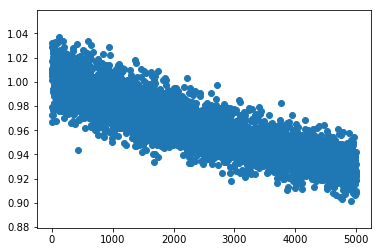

In [15]:
x = range(len(dots))
plt.scatter(x, dots)

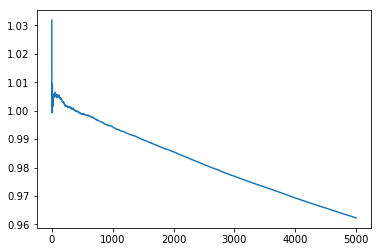

In [16]:
plt.plot(x, dots_2)

In [17]:
def get_prediction(user_id, left, right, net=net):

    # get random batch 
    user_ids = Variable(torch.from_numpy(np.array([user_id]).astype(int)))
    left_ids = Variable(torch.from_numpy(np.array([left]).astype(int)))
    right_ids = Variable(torch.from_numpy(np.array([right]).astype(int)))
    
    embedding_user = net.user_latents(user_ids)
    embedding_left = net.item_latents(left_ids)
    embedding_right = net.item_latents(right_ids) 
    
    xr = torch.cat((embedding_user,embedding_right), dim=1)
    xl = torch.cat((embedding_user,embedding_left), dim=1)
    
    # get predictions
    # А здесь от i отнимаем i*
    # Убрали 
    net_margins = net.forward(xl,xr)
    return net_margins


In [18]:
# My tests
# Сдвигает лист вправо удаляя последнее значение.
def right(lst, stop=0):
    for i in range(len(lst) - 1, stop, -1):
        lst[i] = lst[i - 1]
        
items_number = movies.shape[0]
items=list(range(items_number))

def get_range_user(user_id=1, top=10, items=items):
    res = [0] * top
    i_s = 0
    if get_prediction(user_id, items[0], items[1]) > get_prediction(user_id, items[1], items[0]):
        res[0] = items[0]
        res[1] = items[1]
        i_s = items[0]
    else:
        res[0] = items[1]
        res[1] = items[0]
        i_s = items[1]
    k = top - 1
    for i in items:
        i_s = res[0]
        j = 0
        while((j <= k) and (float(get_prediction(user_id, res[j], i).data.numpy()) > 
                            get_prediction(user_id, i, res[j]).data.numpy())):
            j += 1
        if j <= k:
            right(res, j)
            res[j] = i      
    return res

In [19]:
def ranked_test(test_users=range(30),top=10):
    finded_items = []
    finded_ids = []
    for user_id in test_users:
        items_list = list(ratings_test_good[ratings_test_good.user_id==user_id].movie_id.values)
        test_list = list(ratings_test[ratings_test.user_id == user_id].movie_id.values)
        our_top = get_range_user(user_id=user_id, items=test_list, top=top)
        counter = 0.
        for it in our_top:
            if it in items_list:
                counter += 1
                finded_ids.append([it,len(items_list), len(test_list)])
        finded_items.append(counter)
    return finded_items, finded_ids

In [ ]:
%%time
finded_items, finded_ids = ranked_test(test_users=range(30), top=10)

In [21]:
np.mean(finded_items)

6.4000000000000004

In [22]:
finded_items

[5.0,
 7.0,
 5.0,
 9.0,
 4.0,
 8.0,
 6.0,
 10.0,
 10.0,
 9.0,
 5.0,
 9.0,
 7.0,
 6.0,
 4.0,
 9.0,
 6.0,
 7.0,
 6.0,
 5.0,
 6.0,
 7.0,
 8.0,
 10.0,
 9.0,
 4.0,
 4.0,
 7.0,
 9.0,
 8.0]

In [23]:
finded_ids

[[59, 158, 262],
 [63, 158, 262],
 [197, 158, 262],
 [78, 158, 262],
 [191, 158, 262],
 [301, 36, 52],
 [126, 36, 52],
 [284, 36, 52],
 [13, 36, 52],
 [305, 36, 52],
 [0, 36, 52],
 [291, 36, 52],
 [343, 12, 44],
 [330, 12, 44],
 [259, 12, 44],
 [326, 12, 44],
 [339, 12, 44],
 [257, 12, 14],
 [49, 12, 14],
 [299, 12, 14],
 [323, 12, 14],
 [302, 12, 14],
 [300, 12, 14],
 [326, 12, 14],
 [287, 12, 14],
 [10, 12, 14],
 [41, 57, 165],
 [168, 57, 165],
 [421, 57, 165],
 [28, 57, 165],
 [271, 128, 201],
 [7, 128, 201],
 [123, 128, 201],
 [509, 128, 201],
 [152, 128, 201],
 [466, 128, 201],
 [431, 128, 201],
 [0, 128, 201],
 [388, 270, 393],
 [100, 270, 393],
 [527, 270, 393],
 [670, 270, 393],
 [483, 270, 393],
 [216, 270, 393],
 [232, 35, 49],
 [509, 35, 49],
 [221, 35, 49],
 [21, 35, 49],
 [180, 35, 49],
 [402, 35, 49],
 [510, 35, 49],
 [54, 35, 49],
 [126, 35, 49],
 [194, 35, 49],
 [6, 12, 12],
 [285, 12, 12],
 [384, 12, 12],
 [49, 12, 12],
 [370, 12, 12],
 [5, 12, 12],
 [241, 12, 12],
 [3

In [24]:
na = np.array(finded_ids)
rr = np.sum(na[:, 1]) / np.sum(na[:, 2])
print(rr)

0.607695473251


In [24]:
movies[movies.movie_id.isin(finded_ids)]

,movie_id,title,release_date,video_release_date,imdb_url
6,6,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...
49,49,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...
63,63,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...
79,79,Hot Shots! Part Deux (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Hot%20Shots!%...
84,84,"Ref, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Ref,%20The%20..."
117,117,Twister (1996),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Twister%20(1996)
131,131,"Wizard of Oz, The (1939)",01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?Wizard%20of%2...
152,152,"Fish Called Wanda, A (1988)",01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Fish%20Called...
163,163,"Abyss, The (1989)",01-Jan-1989,NaN,"http://us.imdb.com/M/title-exact?Abyss,%20The%..."
164,164,Jean de Florette (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Jean%20de%20F...


In [54]:
ratings_all[(ratings_all.user_id == 2) & (ratings_all.rating == 1)].merge(movies, left_on='movie_id', right_on='movie_id')

,user_id,movie_id,rating,RN,title,release_date,video_release_date,imdb_url
0,2,330,1,25,"Edge, The (1997)",26-Sep-1997,NaN,http://us.imdb.com/M/title-exact?Edge%2C+The+(...
1,2,327,1,28,Conspiracy Theory (1997),08-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Conspiracy+Th...
2,2,317,1,38,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...
3,2,347,1,8,Desperate Measures (1998),30-Jan-1998,NaN,http://us.imdb.com/Title?Desperate+Measures+(1...
4,2,326,1,29,Cop Land (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Cop+Land+(1997)
5,2,320,1,35,Mother (1996),25-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Mother%20(199...
6,2,259,1,51,Event Horizon (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Event+Horizon...
7,2,319,1,36,Paradise Lost: The Child Murders at Robin Hood...,06-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Paradise%20Lo...
8,2,341,1,14,"Man Who Knew Too Little, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Man+Who+Knew+...
9,2,328,1,27,Desperate Measures (1998),30-Jan-1998,NaN,http://us.imdb.com/Title?Desperate+Measures+(1...
